## 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

#### 1. 라이브러리 버전 확인

In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.1.3
0.6.0
4.2.0


#### 2. 데이터 준비와 확인

In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('./data/ratings_train.txt')
test_data = pd.read_table('./data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


#### 3. 데이터 로더 구성

- 결측치 확인

In [4]:
train_data.isnull().sum()

id          0
document    5
label       0
dtype: int64

In [8]:
test_data.isnull().sum()

id          0
document    3
label       0
dtype: int64

리뷰 내용에서 결측치가 있다. 삭제하겠다

- 데이터의 중복 제거

In [15]:
train_data[train_data.duplicated(['id'])==True]
test_data[test_data.duplicated(['id'])==True]

,id,document,label


id 부문에서 중복되는 사항은 없다

In [16]:
train_data[train_data.duplicated(['document'])==True]
test_data[test_data.duplicated(['document'])==True]

,id,document,label
857,2084375,bad,0
956,195683,재미있어요,1
1089,2235528,볼만함,1
1149,4409686,굿,1
1600,3805716,최고,1
...,...,...,...
49731,7437033,별로,0
49760,5890883,최악이다,0
49767,4032953,최고,1
49841,8097768,2년이 지나도 잊혀지지 않는 소중한 드라마.,1


리뷰 내용에서 최고 굿 등으로 중복되는 내용은 있지만 id가 중복되는 것도 없고 해서 지우지 않겠다

- 한국어 토크나이즈
- 불용어 제거 

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
   #결측치 제거 
    train_data=train_data.dropna()
    test_data=test_data.dropna()
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

Exception: Install MeCab in order to use it: http://konlpy.org/en/latest/install/

 MeCab 설치를 했는데도 돌아가지 않아서 클라우드 주피터 노트북으로 진행했습니다 ㅜ

In [ ]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [ ]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [ ]:
# 처음 몇 개 인덱스는 사전에 정의되어 있습니다.
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

인덱스 추가

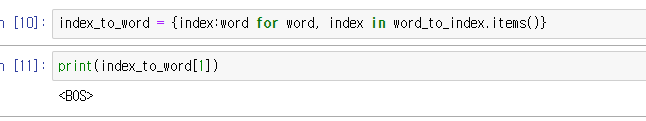

인덱스 추가됨을 확인하였다

In [ ]:
# 보정 후 x_train[0] 데이터
a=get_decoded_sentence(X_train[0], index_to_word)
print(get_decoded_sentence(X_train[0], index_to_word))

print(get_encoded_sentence(a, word_to_index)) 


print(index_to_word[74])
print(index_to_word[921])
print(index_to_word[2])

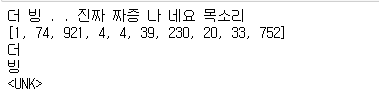

#### 3. 모델 구성을 위한 데이터 분석 및 가공

- 데이터 길이

In [ ]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

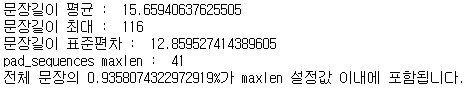

패딩은 포스트로 하여 훈련 시켯다

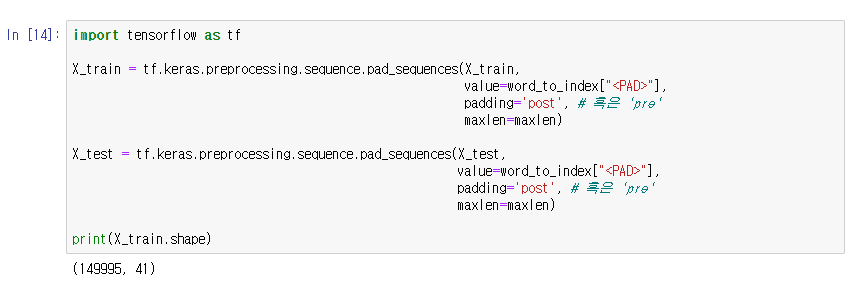

## 5) 모델 구성 및 validation set 구성

- 기존 모델

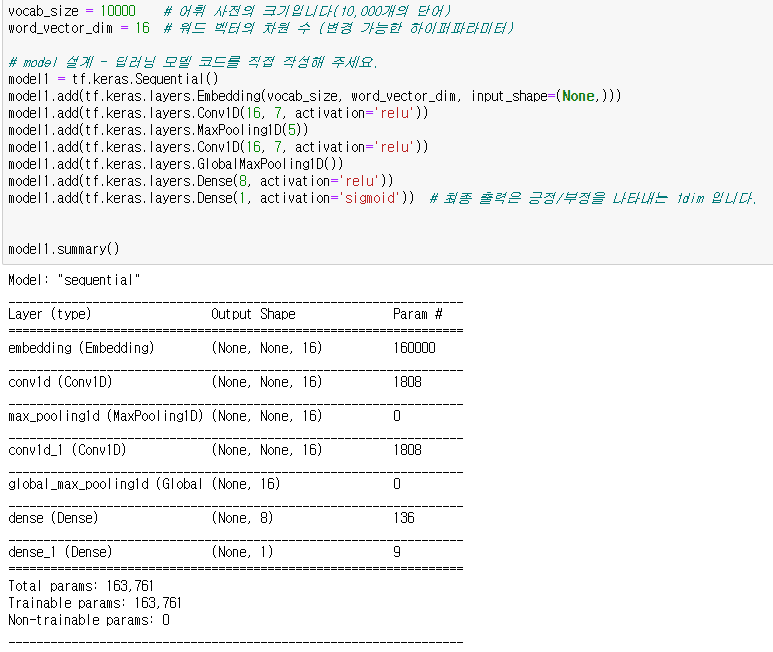

validation set 분리

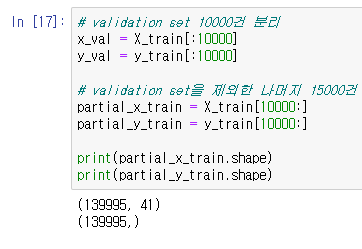

- 모델 훈련 
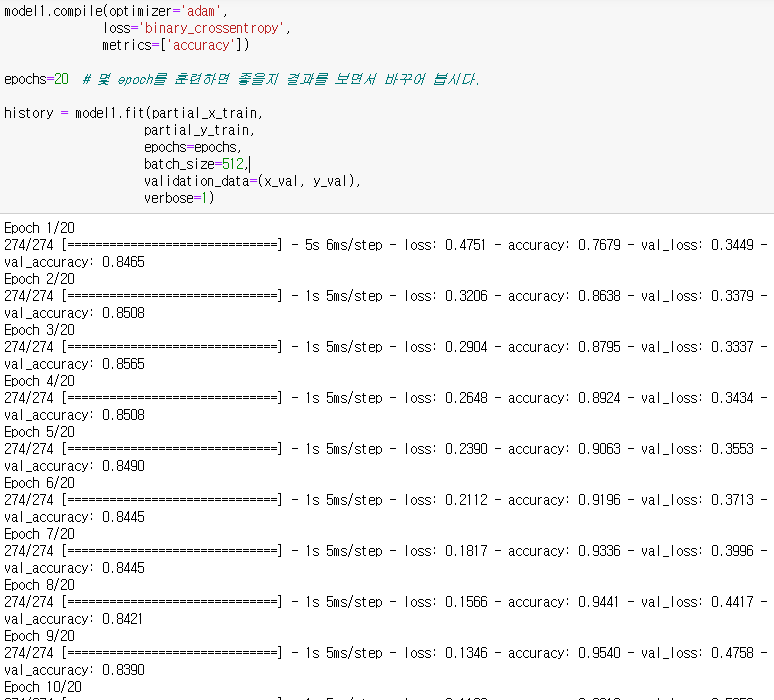
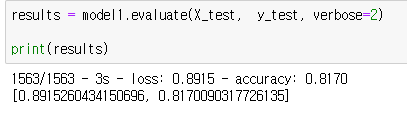

훈련 후 정확도 밀 로스에 관한 함수 그리기

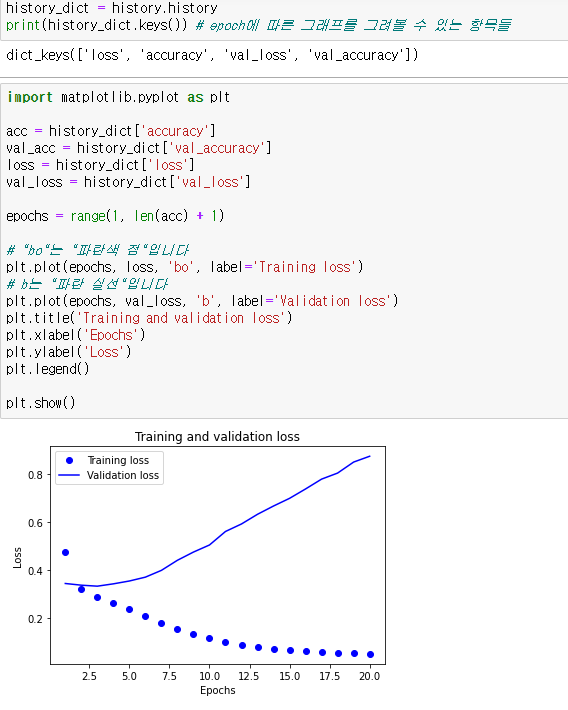
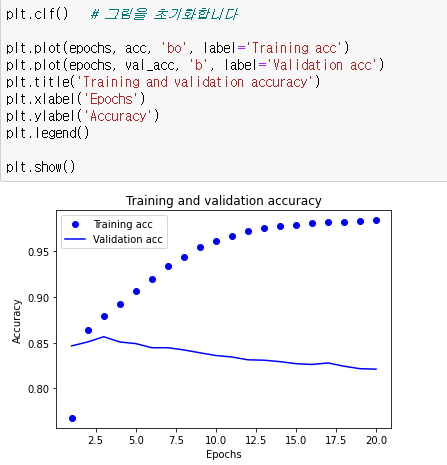

traing 세트에 비해 검증 부분은 정확도가 잘 나오지 않아 일단 반복도를 다르게 하여 돌려보았다.

- 10번만 적게 돌렸을 경우

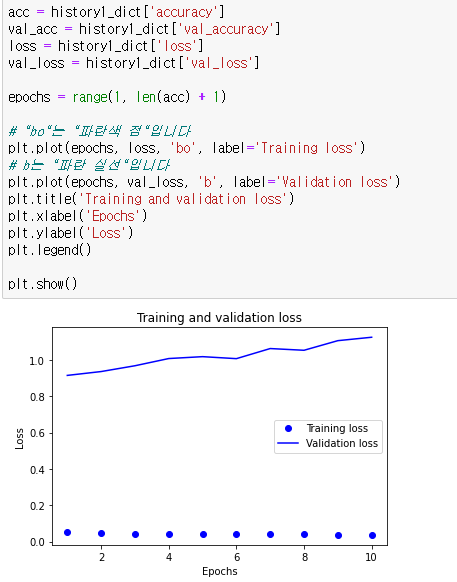
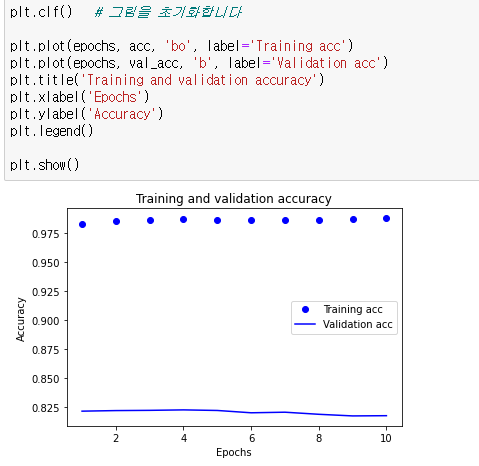

너무 낮은 반복량이라 그런지 validation set에 관한 로스율이 특히 높다

- 30번 돌렸을 때

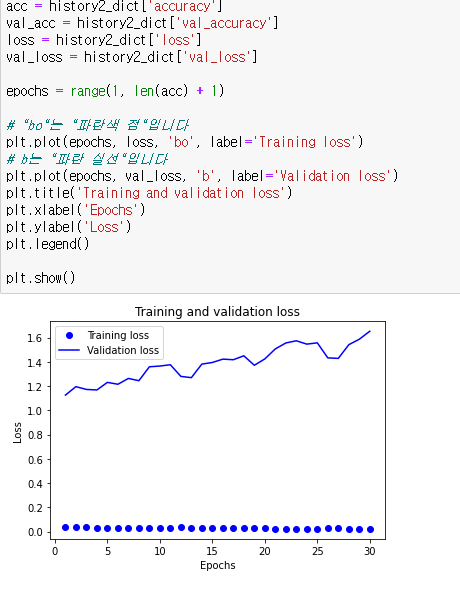
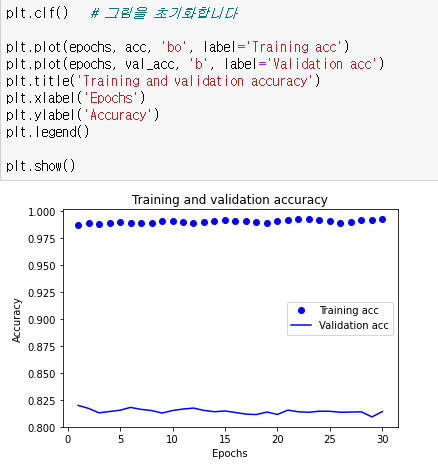

오히려 20번 돌렸을 때보다 떨어지는 validarion set에 대한 정확도와 로스가 보인다. 오버 피팅 된 것일까? 트레이닝 정확도는 거의 1에 가깝다. 오버피팅 된 것으로 생각되어진다. 10번 돌렸을 때와 비슷한 양상을 보여 반복도는 20을 유지하는 것으로 진행하였다.

#####  두번쨰 모델 

- LSTM 레이어를 사용한다.
임베딩에 최적화된 LSTM 레이어를 가볍게 사용해보기로 했다.

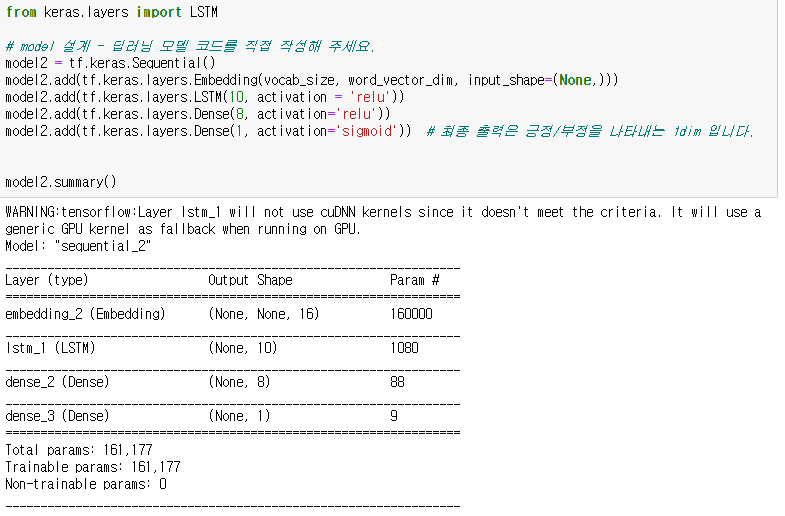

모델 훈련 
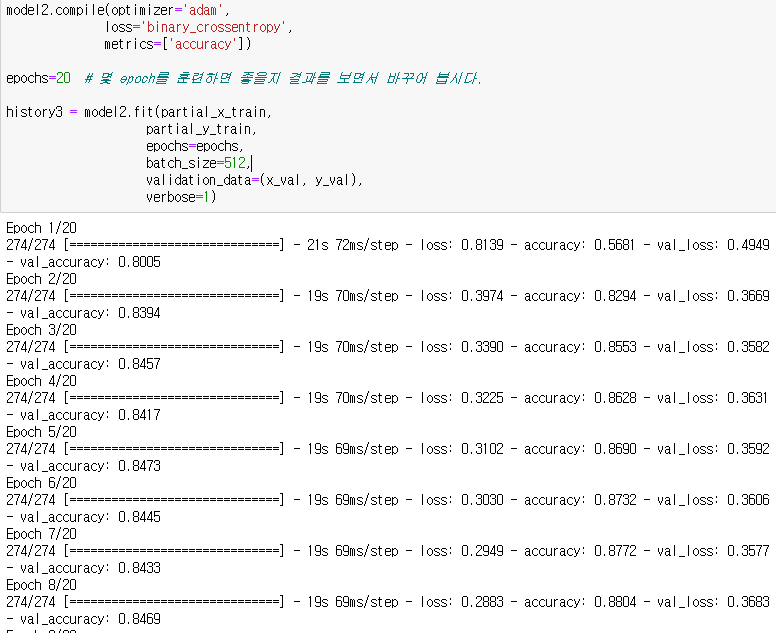

그래프 
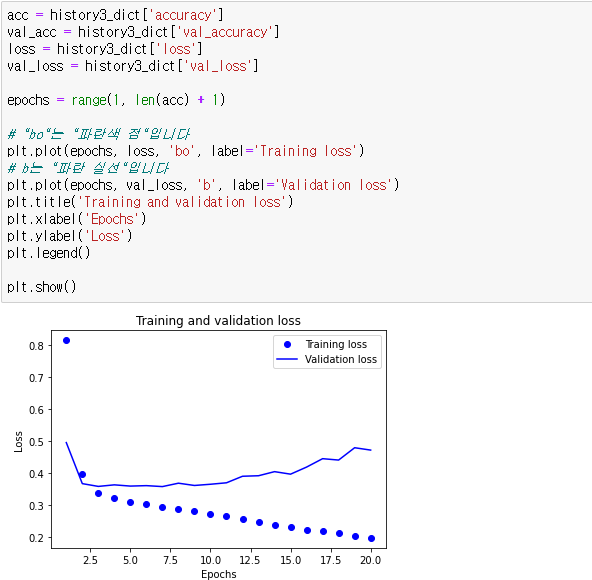
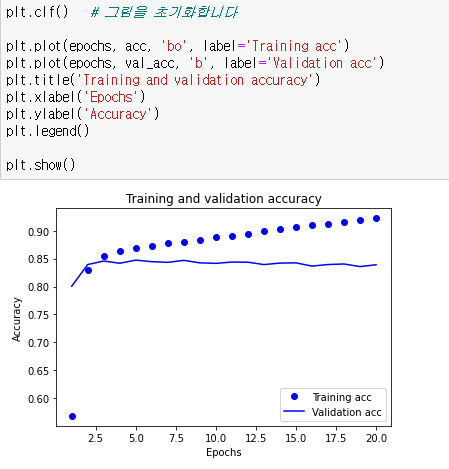

D오 LSTM 레이어를 추가만 하고 DENSE 레이어만 있는데도 기존의 모델들의 그래프보다 트레이닝 라인을 따라가는 그래프를 보여준다. 특히 로스율이 많이 줄었다!

그래서 lstm 레이어와 dense 레이어를 더 깊ㄷ게 쌓으면 어떻게 될지 세번째 모델로 진행하였다

#### 세번쨰 모델 
- lstm 레이어를 깊게 쌓는다

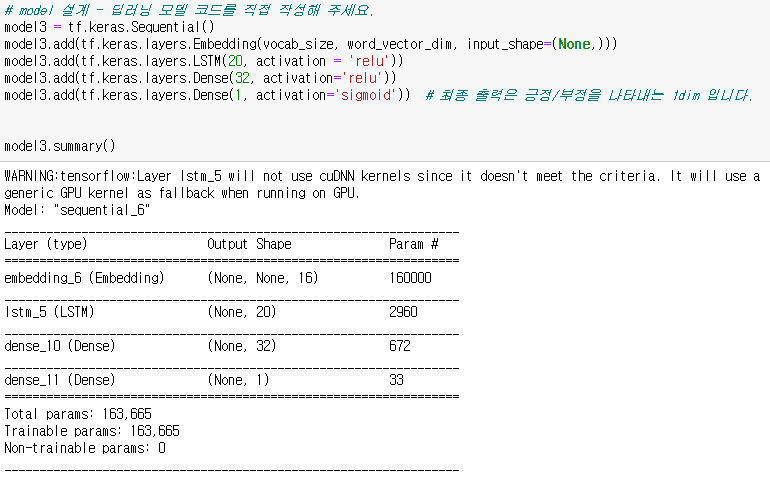

그래프 
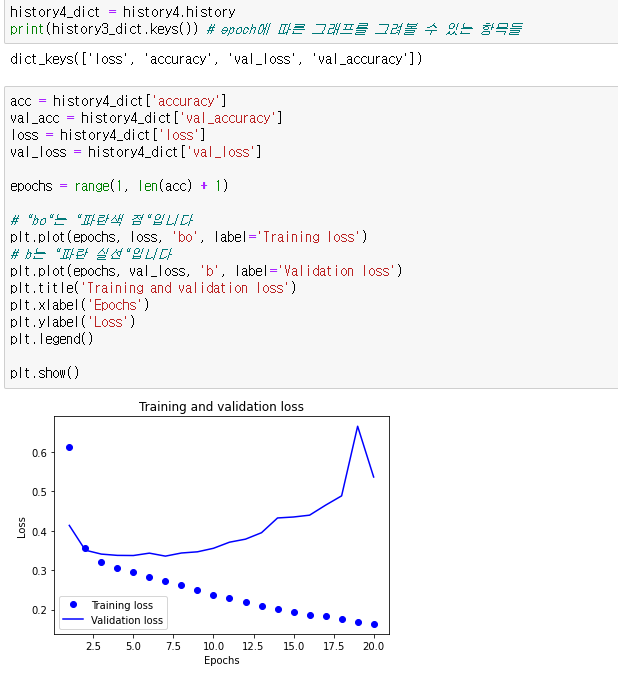
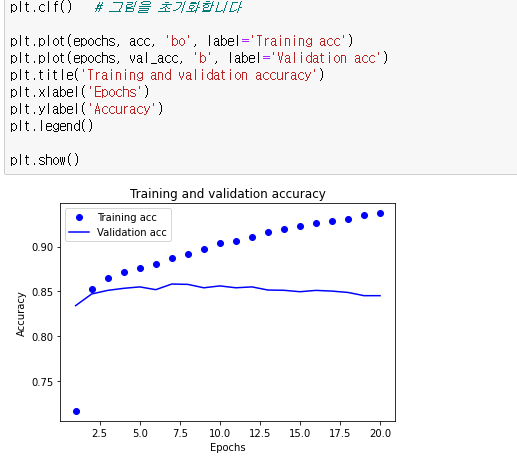

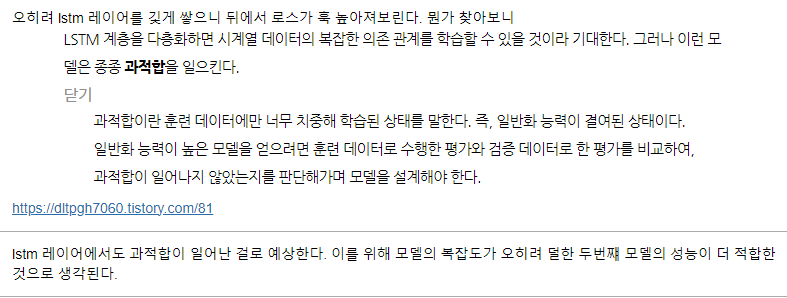

## 임베딩 분석

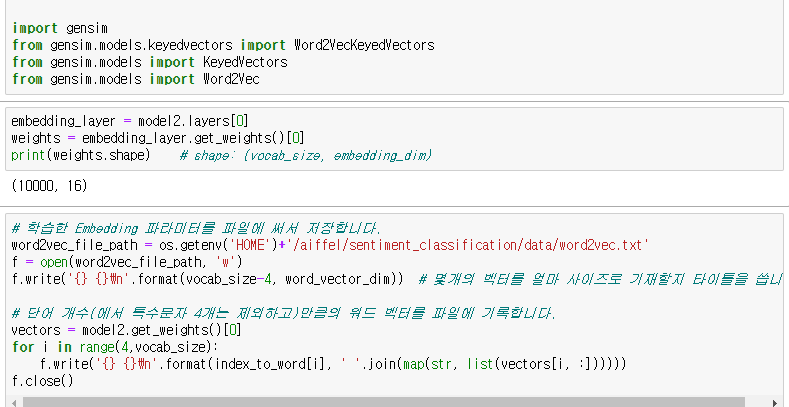

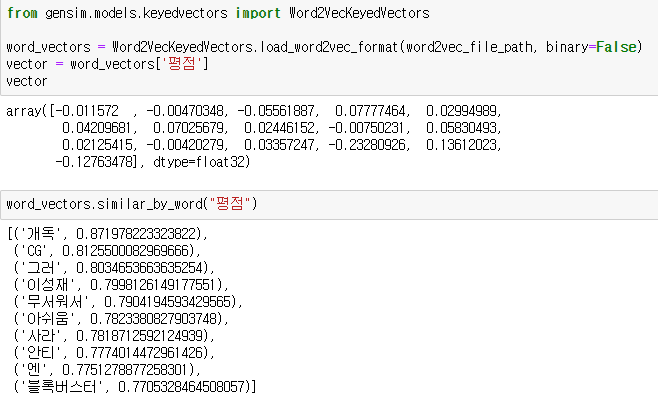

## 한국어 Word2Vec 임베딩 활용하여 성능 개선

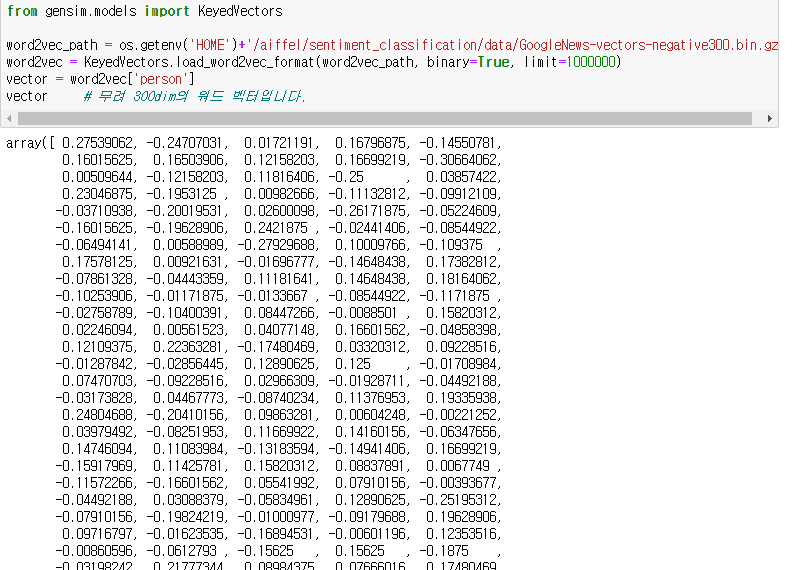

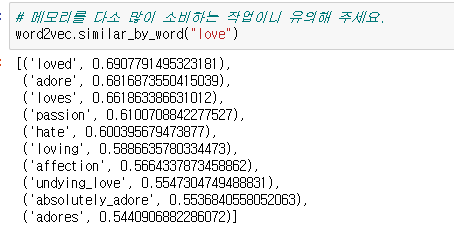

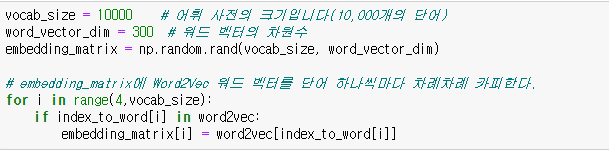

위에서 언급한 정확도가 제일 높은 모델 2를 모티브로 모델을 구성하였다 
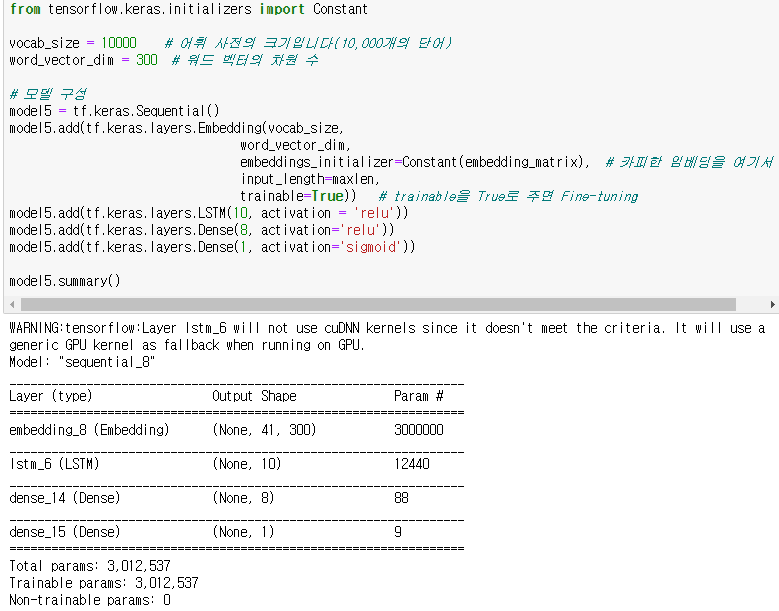

모델 훈련
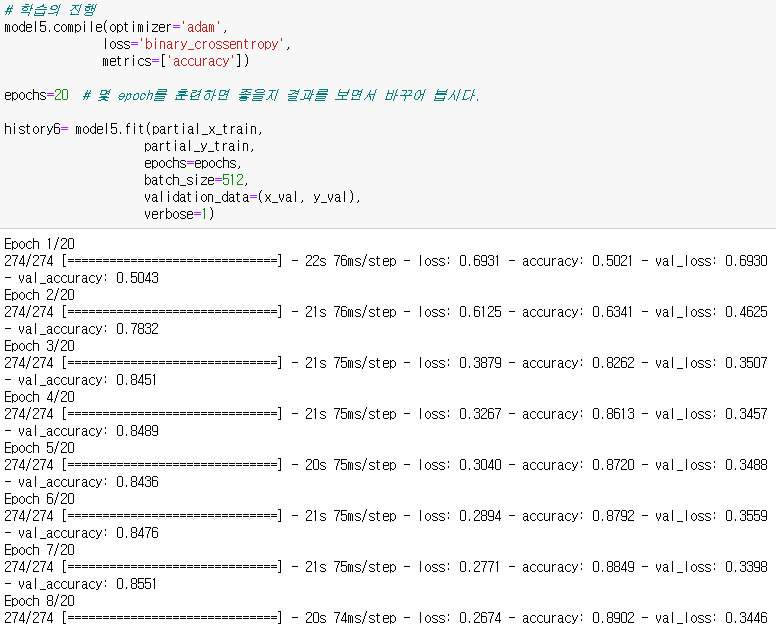

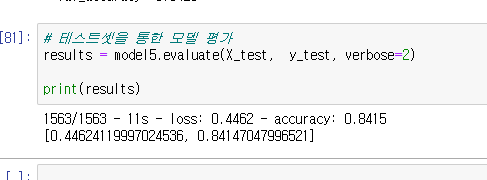

최종 정확도가 0.84 정도 나왓다. 
아래 이미지가 WORD2VEC모델 2에 대한 처리를 하기전 정확도이다.
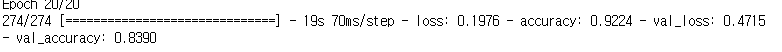

0.002 정도 정확도가 향상되긴 했다.. 향상됬네..

## 회고

이것도 85% 라고 쳐주시면 안될까요 0.8414704 인데.. 

여튼 해보면서 컴퓨터가 단어를 실제로 이해하는건 ㄴ아니지만 유사도, 벡터를 통해 단어간의 연관성을 아는 것이 참 묘했다. 

그리고 LSTM에 대한 레이어를 넣으니 로스가 굉장히 많이 떨어져서 임베딩에 적합한 레이어로 왜 LSTM이 언급되는지 느낄 수 있었다.

그래도 난 자연어 처리 너무 어려워요 ㅜㅜ 이미지가 더 좋아